In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
plt.style.use('fivethirtyeight')

import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import scipy as stats

#TBATS forecasting methods
import tbats
from tbats import TBATS, BATS

#Auto arima/sarima package
import pmdarima as pm
from pmdarima.arima import auto_arima

#Facebook Prophet Package
from fbprophet import Prophet

#To save models as binary on disk
import pickle



print('Imports Complete')



#New Source
#https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

Imports Complete


<font size="4">Read in the 4 community time series files. </font> 

In [110]:
#Take in files for communities
com0=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_0.csv')

com1=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_1.csv')

com2=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_2.csv')

com3=pd.read_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\df_community_3.csv')

community_names=[com0,com1,com2,com3]

for com in community_names:
    
    com['time']=pd.to_datetime(com['time'])
    
    com.set_index('time',inplace=True)
    
    
    


<font size="4">Plotting the first few weeks of each time series shows that each series behaves similarly, but are not exactly the same. </font> 

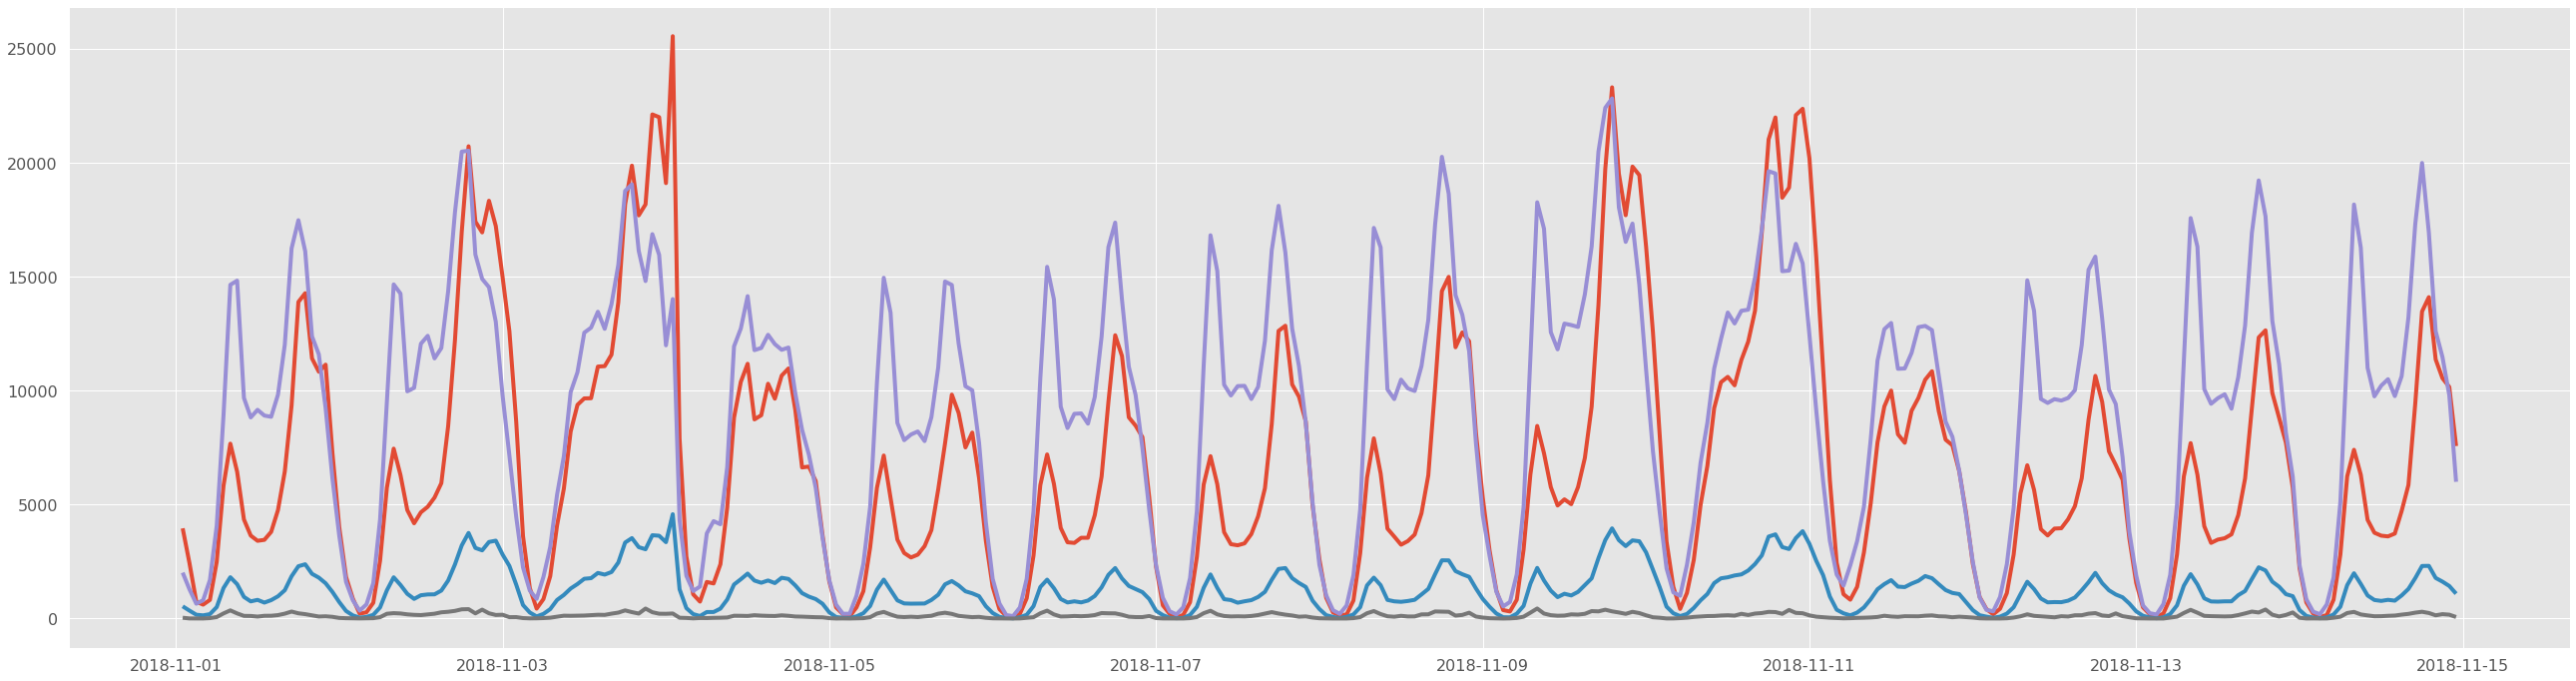

In [111]:
#Set axis size
fig, ax=plt.subplots(figsize=(40,11))

#Set plot style
style.use('ggplot')

plt.plot(com0.iloc[1:336])
plt.plot(com1.iloc[1:336])
plt.plot(com2.iloc[1:336])
plt.plot(com3.iloc[1:336])

<font size="4"> Replotting community 3 so that it is visible </font>

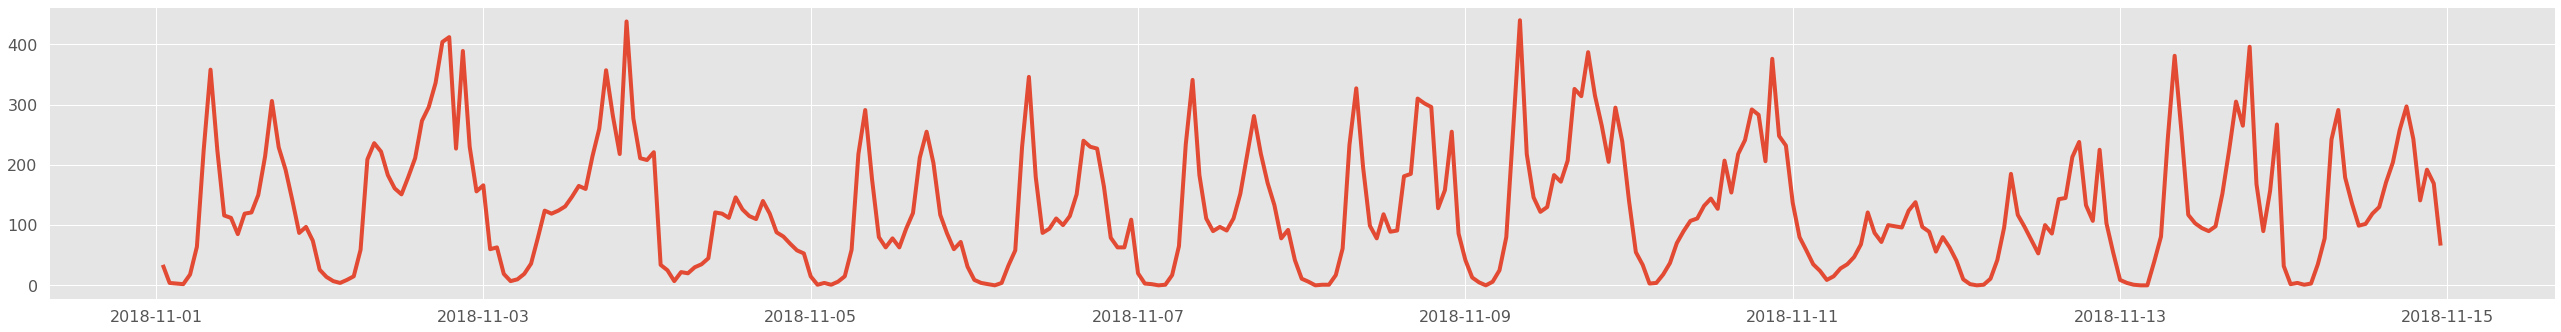

In [117]:
#Set axis size
fig, ax=plt.subplots(figsize=(40,5))

#Set plot style
style.use('ggplot')

plt.plot(com3.iloc[1:336])

<font size="4"> Next we test each series for stationarity. Achieving stationarity is necessary for time series modeling. </font>
<br>
<br>
<font size="4"> The Augmented Dickey Fuller Test has a null hypothesis that the series is NOT stationary. Below, you can see that the P-Values are all less than .05, showing the series are stationary. </font>

In [121]:
def test_stationarity(timeseries):
    
    print('Results of Dickey-Fuller Test:')
    timeseries=timeseries.dropna()
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
community_list=[com0,com1,com2,com3]

for community in community_list:
    test_stationarity(community)

Results of Dickey-Fuller Test:
Test Statistic                -7.946464e+00
p-value                        3.210133e-12
#Lags Used                     3.000000e+01
Number of Observations Used    3.593000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567198e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.293939e+00
p-value                        1.393779e-10
#Lags Used                     3.000000e+01
Number of Observations Used    3.593000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+00
Critical Value (10%)          -2.567198e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -5.829289e+00
p-value                        4.010254e-07
#Lags Used                     3.000000e+01
Number of Observations Used    3.593000e+03
Critical Value (1%)           -3.432171e+00
Critical Value (5%)           -2.862345e+

# Training sets using the full time series
<br>
Make testing and training sets for each community.
<br>
Each training set will contain the full dataset less the last two weeks.
<br>
The last two weeks will be used as the out of sample test.

In [177]:
#Make testing and training sets for each community

#Community 0
com0_y = com0['trip_count']

com0_y_to_train = com0_y.iloc[:(len(com0_y)-336)]

com0_y_to_test = com0_y.iloc[(len(com0_y)-336):] # last two weeks for testing

#Community 1
com1_y = com1['trip_count']

com1_y_to_train = com1_y.iloc[:(len(com1_y)-336)]

com1_y_to_test = com1_y.iloc[(len(com1_y)-336):] # last two weeks for testing

#Community 2
com2_y = com2['trip_count']

com2_y_to_train = com2_y.iloc[:(len(com2_y)-336)]

com2_y_to_test = com2_y.iloc[(len(com2_y)-336):] # last two weeks for testing

#Community 3
com3_y = com3['trip_count']

com3_y_to_train = com3_y.iloc[:(len(com3_y)-336)]

com3_y_to_test = com3_y.iloc[(len(com3_y)-336):] # last two weeks for testing

# Training sets using the last 10 weeks to train
<br>
Make testing and training sets for each community using the last 10 weeks.
<br>
The last two weeks will be used as the out of sample test.

In [186]:
#Make testing and training sets for each community

#Community 0
com0_y = com0['trip_count']

com0_y_to_train = com0_y.iloc[len(com0_y)-1008:(len(com0_y)-336)]

com0_y_to_test = com0_y.iloc[(len(com0_y)-336):] # last two weeks for testing

#Community 1
com1_y = com1['trip_count']

com1_y_to_train = com1_y.iloc[len(com1_y)-1008:(len(com1_y)-336)]

com1_y_to_test = com1_y.iloc[(len(com1_y)-336):] # last two weeks for testing

#Community 2
com2_y = com2['trip_count']

com2_y_to_train = com2_y.iloc[len(com2_y)-1008:(len(com2_y)-336)]

com2_y_to_test = com2_y.iloc[(len(com2_y)-336):] # last two weeks for testing

#Community 3
com3_y = com3['trip_count']

com3_y_to_train = com3_y.iloc[len(com3_y)-1008:(len(com3_y)-336)]

com3_y_to_test = com3_y.iloc[(len(com3_y)-336):] # last two weeks for testing

# Using TBATS model with two seasonal periods, train and forecast using the first 4 train and test sets

In [125]:
#Setup TBATS Model with seasonality for 24 hours (1 day) and 168 hours (1 week)
estimator = TBATS(seasonal_periods=(24, 168))

In [141]:
#Fit and forecast community 0
com0_model = estimator.fit(com0_y_to_train)

# Forecast 336 hours ahead
com0_y_forecast_full = com0_model.forecast(steps=336)

In [127]:
#Fit and forecast community 1
com1_model = estimator.fit(com1_y_to_train)

# Forecast 336 hours ahead
com1_y_forecast_full = com1_model.forecast(steps=336)

In [128]:
#Fit and forecast community 2
com2_model = estimator.fit(com2_y_to_train)

# Forecast 336 hours ahead
com2_y_forecast_full = com2_model.forecast(steps=336)

In [129]:
#Fit and forecast community 3
com3_model = estimator.fit(com3_y_to_train)

# Forecast 336 hours ahead
com3_y_forecast_full = com3_model.forecast(steps=336)

In [130]:
model_list=[com0_model,com1_model,com2_model,com3_model]
for model in model_list:
    print(model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [ 24. 168.]
Seasonal harmonics [11  6]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.735285
Trend (Beta): -0.316218
Damping Parameter (Phi): 0.853773
Seasonal Parameters (Gamma): [2.42745382e-05 1.03347561e-04 2.61076021e-05 1.63286784e-04]
AR coefficients []
MA coefficients []
Seed vector [ 5156.32555192   387.29085851    21.79981321 -1126.02789849
   558.66415593   343.8182985   -209.72027056  -153.00001442
  -159.52329226    20.28673822    59.88910591    48.2055878
    23.0465739  -4909.45650198 -2702.52909637   505.8723049
   431.23803851  -563.95117449  -180.61938198   217.37037225
   109.63802399   -10.77903732   -48.20050679   -22.79538832
  1516.52783516 -1270.34932915  -784.4169949   -247.44891681
  -186.41977707  1346.40839626 -3203.97698299  -773.4445251
   187.345491     492.92356598  1077.23192133  1097.37969428]

AIC 28557.141588
Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal

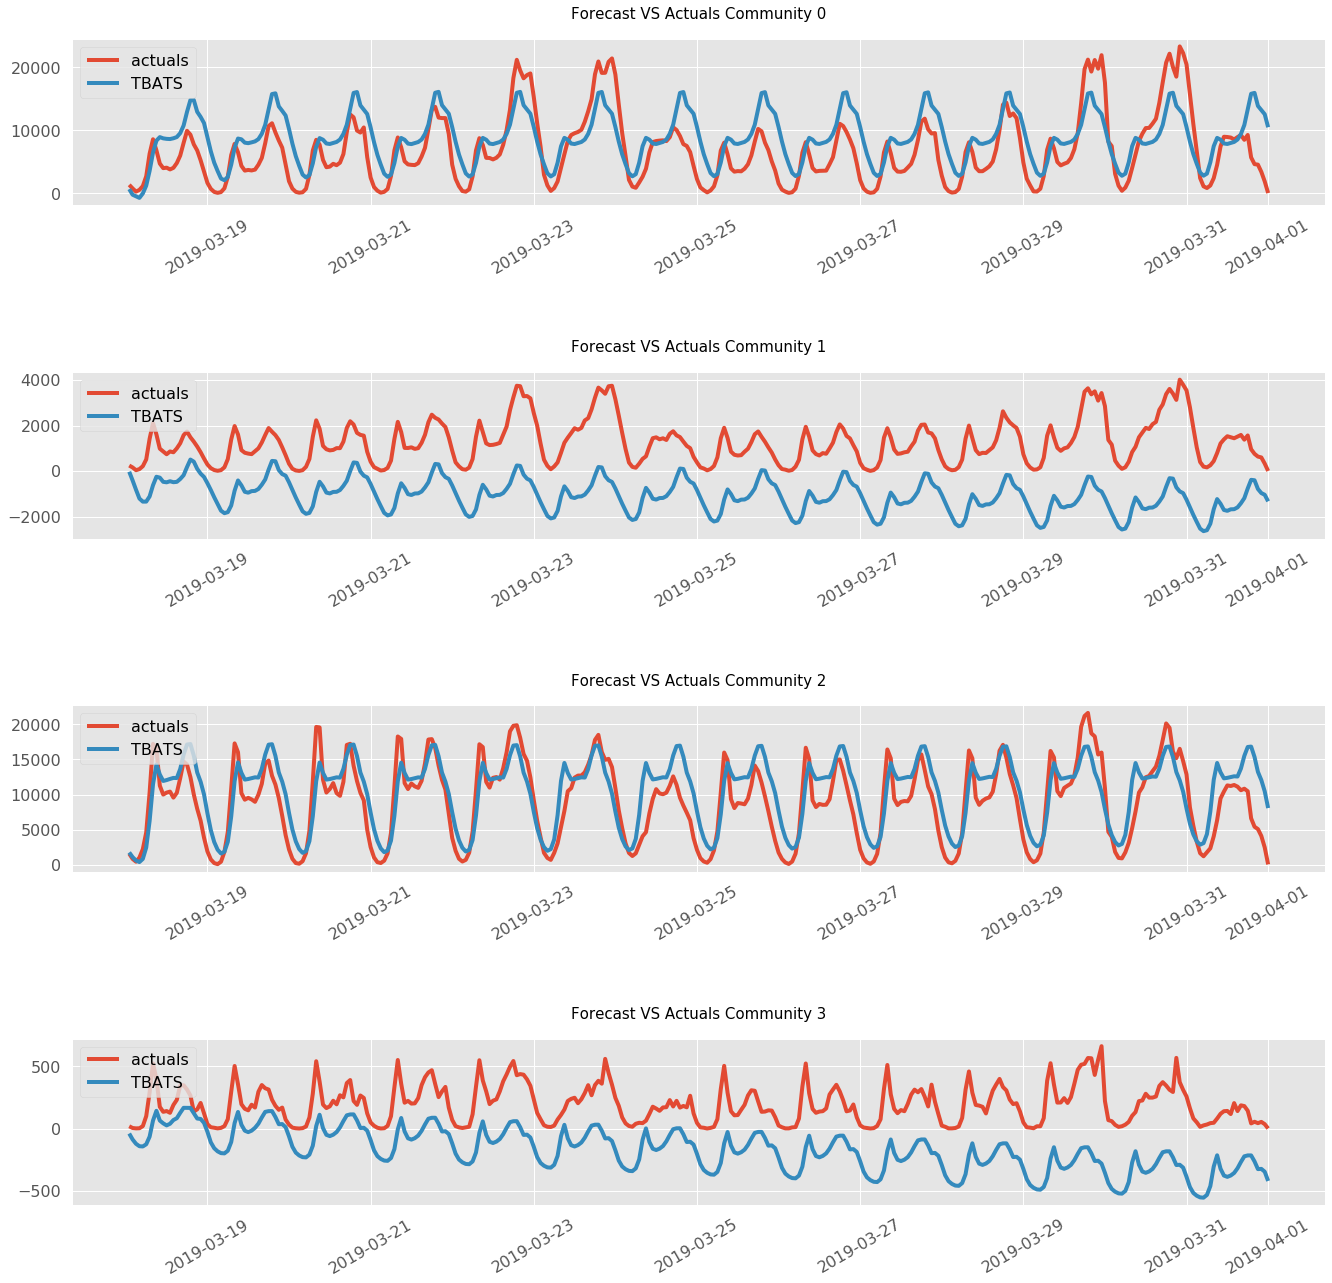

In [184]:
#Plot test and actual values for last 2 weeks of dataset 

fig, (ax1,ax2,ax3,ax4)=plt.subplots(4,1,figsize=(20,20))
fig.subplots_adjust(hspace=1)
plt.xticks(rotation=90)

#Function to plot TBATS test results
def plot_test_tbats(actual,forecast,ax,title):
    
    test_df=pd.DataFrame(data={'actual':actual,'tbats_forecast':forecast})
          
    ax.plot(test_df.actual,label='actuals')
    
    ax.plot(test_df.tbats_forecast,label='TBATS')
    
        
    ax.legend(loc='upper left')
    
    ax.set_title(title,fontsize=15,pad=20)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

        
#Plot for community 0
plot_test_tbats(com0_y_to_test,com0_stepwise_sarima_forecast,ax1,'Forecast VS Actuals Community 0')
    
#Plot for community 1
plot_test_tbats(com1_y_to_test,com1_stepwise_sarima_forecast,ax2,'Forecast VS Actuals Community 1')

#Plot for community 2
plot_test_tbats(com2_y_to_test,com2_stepwise_sarima_forecast,ax3,'Forecast VS Actuals Community 2')

#Plot for community 3
plot_test_tbats(com3_y_to_test,com3_stepwise_sarima_forecast,ax4,'Forecast VS Actuals Community 3')


In [144]:
#Pickle the pickup models for each community by saving them as binary on the disk

#To Read:
#with open('mypickle.pickle','rb') as f:
    #loaded_obj = pickle.load(f)

with open('com0_model.pickle', 'wb') as f:
    pickle.dump(com0_model, f)
    
with open('com1_model.pickle', 'wb') as f:
    pickle.dump(com1_model, f)

with open('com2_model.pickle', 'wb') as f:
    pickle.dump(com2_model, f)
    
with open('com3_model.pickle', 'wb') as f:
    pickle.dump(com3_model, f)


In [179]:
com0_stepwise_sarima = pm.auto_arima(com0_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24,
                             start_P=0, seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=57139.794, BIC=57170.283, Fit time=7.334 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=59722.121, BIC=59734.316, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=57058.877, BIC=57083.268, Fit time=5.816 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=57267.576, BIC=57291.967, Fit time=5.598 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=58202.987, BIC=58221.281, Fit time=0.191 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=57022.394, BIC=57052.883, Fit time=26.345 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=57984.299, BIC=58008.689, Fit time=29.443 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=56765.361, BIC=56801.947, Fit time=34.415 seconds
Fit ARIMA: order=(2, 

In [180]:
com1_stepwise_sarima = pm.auto_arima(com1_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24,
                             start_P=0, seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

com2_stepwise_sarima = pm.auto_arima(com2_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24,
                             start_P=0, seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

com3_stepwise_sarima = pm.auto_arima(com3_y_to_train, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=24,
                             start_P=0, seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=46254.609, BIC=46285.098, Fit time=5.662 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=48616.460, BIC=48628.656, Fit time=0.081 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 24); AIC=46091.178, BIC=46115.569, Fit time=4.709 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 24); AIC=46320.492, BIC=46344.883, Fit time=4.318 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 24); AIC=47342.522, BIC=47360.815, Fit time=0.160 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 24); AIC=46067.655, BIC=46098.143, Fit time=22.792 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=45693.035, BIC=45729.621, Fit time=140.441 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 1, 24); AIC=45579.679, BIC=45622.363, Fit time=47.463 seconds
Fit ARIMA: order=(2,

In [181]:

com0_stepwise_sarima_forecast=com0_stepwise_sarima.predict(n_periods=336)

com1_stepwise_sarima_forecast=com1_stepwise_sarima.predict(n_periods=336)

com2_stepwise_sarima_forecast=com2_stepwise_sarima.predict(n_periods=336)

com3_stepwise_sarima_forecast=com3_stepwise_sarima.predict(n_periods=336)



In [182]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
       
    return({'mape':mape, 'rmse':rmse})

#Forecast Accuracy of SARIMA
print(forecast_accuracy(com0_stepwise_sarima_forecast,com0_y_to_test))

#Forecast Accuracy of TBATS
print(forecast_accuracy(com0_y_forecast_full,com0_y_to_test))



#Forecast Accuracy of TBATS
print(forecast_accuracy(df1.yhat.values,com0_y_to_test))

print(forecast_accuracy(com1_stepwise_sarima_forecast,com1_y_to_test))
print(forecast_accuracy(com2_stepwise_sarima_forecast,com2_y_to_test))
print(forecast_accuracy(com3_stepwise_sarima_forecast,com3_y_to_test))


{'mape': 3.953705409751326, 'rmse': 4430.519085050518}
{'mape': 2.380624016543718, 'rmse': 2951.861470769391}
{'mape': 1.83348730338674, 'rmse': 1887.5152162854583}
{'mape': 7.481227395668934, 'rmse': 2470.695730129777}
{'mape': 1.452317396385478, 'rmse': 3499.839378492765}
{'mape': inf, 'rmse': 399.5218074820735}


In [64]:
com0_y_prophet=com0_y.reset_index()

com0_y_prophet.columns=['ds','y']


com0_y_prophet.y, lambda_prophet = stats.boxcox(com0_y_prophet['y'])

com0_y_prophet_to_train = com0_y_prophet.iloc[:(len(com0_y_prophet)-336)]

com0_y_prophet_to_test = com0_y_prophet.iloc[(len(com0_y_prophet)-336):] 


param_list=[.01,.02,.03,.04,.05,.06]

for p in param_list:

    my_model = Prophet(changepoint_prior_scale=p,weekly_seasonality=50,interval_width=0.90)

    my_model.add_country_holidays(country_name='US')

    my_model.fit(com0_y_prophet_to_train)

    future_dates = my_model.make_future_dataframe(periods=336, freq='1h')
    
    forecast = my_model.predict(future_dates)
    
    
    
    df1=forecast[['yhat','ds']]

    df1=df1.set_index('ds')

    df1

    df1.yhat=prophet_forecast.values

    df1=df1.iloc[len(df1)-336:]
    
    print(forecast_accuracy(df1.yhat.values,com0_y_to_test))
    
    print(p)


AttributeError: module 'scipy' has no attribute 'boxcox'

In [87]:
com0_y_prophet=com0_y.reset_index()

com0_y_prophet.columns=['ds','y']



com0_y_prophet_to_train = com0_y_prophet.iloc[:(len(com0_y_prophet)-336)]

com0_y_prophet_to_test = com0_y_prophet.iloc[(len(com0_y_prophet)-336):] 

my_model = Prophet(weekly_seasonality=50)

my_model.add_country_holidays(country_name='US')

my_model.fit(com0_y_prophet_to_train)

future_dates = my_model.make_future_dataframe(periods=336, freq='1h')

forecast = my_model.predict(future_dates)
    
df1=forecast[['yhat','ds']]

df1=df1.set_index('ds')

df1=df1.iloc[len(df1)-336:]






INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [79]:

type(df1.yhat)

type(com0_y_to_test)

pandas.core.series.Series

In [335]:
com1_y_prophet=com1_y.reset_index()

com1_y_prophet.columns=['ds','y']


com1_y_prophet.y, lambda_prophet = stats.boxcox(com1_y_prophet['y'])

com1_y_prophet_to_train = com1_y_prophet.iloc[:(len(com1_y_prophet)-336)]

com1_y_prophet_to_test = com1_y_prophet.iloc[(len(com1_y_prophet)-336):] 


param_list=[.8,.85,.9,.95,.99]

for p in param_list:

    my_model = Prophet(interval_width = p,weekly_seasonality=40)

    my_model.add_country_holidays(country_name='US')

    my_model.fit(com1_y_prophet_to_train)

    future_dates = my_model.make_future_dataframe(periods=336, freq='1h')
    
    forecast = my_model.predict(future_dates)
    
    prophet_forecast=inv_boxcox(forecast.yhat,lambda_prophet)
    
    df1=forecast[['yhat','ds']]

    df1=df1.set_index('ds')

    df1

    df1.yhat=prophet_forecast.values

    df1=df1.iloc[len(df1)-336:]
    
    print(forecast_accuracy(df1.yhat.values,com1_y_to_test))
    print(p)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.9089174861221556, 'rmse': 132.24035662480662}
0.8


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.9089174861221556, 'rmse': 132.24035662480662}
0.85


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.9089174861221556, 'rmse': 132.24035662480662}
0.9


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.9089174861221556, 'rmse': 132.24035662480662}
0.95


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


{'mape': 2.9089174861221556, 'rmse': 132.24035662480662}
0.99


In [337]:
com2_y_prophet=com2_y.reset_index()

com2_y_prophet.columns=['ds','y']


com2_y_prophet.y, lambda_prophet = stats.boxcox(com2_y_prophet['y'])

com2_y_prophet_to_train = com2_y_prophet.iloc[:(len(com2_y_prophet)-336)]

com2_y_prophet_to_test = com2_y_prophet.iloc[(len(com2_y_prophet)-336):] 


param_list=[10,20,30,40,50,60,70]

for p in param_list:

    my_model = Prophet(weekly_seasonality=70,holidays_prior_scale=20)

    my_model.add_country_holidays(country_name='US')

    my_model.fit(com2_y_prophet_to_train)

    future_dates = my_model.make_future_dataframe(periods=336, freq='1h')
    
    forecast = my_model.predict(future_dates)
    
    prophet_forecast=inv_boxcox(forecast.yhat,lambda_prophet)
    
    df1=forecast[['yhat','ds']]

    df1=df1.set_index('ds')

    df1

    df1.yhat=prophet_forecast.values

    df1=df1.iloc[len(df1)-336:]
    
    print(forecast_accuracy(df1.yhat.values,com2_y_to_test))
    print(p)
    
    


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.1331640560463465, 'rmse': 466.2521484525474}
10


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.115484299284355, 'rmse': 462.99764158417656}
20


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.137765815718826, 'rmse': 469.08931863500044}
30


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.1292658337451913, 'rmse': 465.3940982347412}
40


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.1288527783392164, 'rmse': 465.1766363883766}
50


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


{'mape': 2.1477280070939773, 'rmse': 468.77114118649365}
60


C:\Users\brhirsch\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


{'mape': 2.1372740654303417, 'rmse': 466.79395678823784}
70


In [314]:
future_dates

forecast = my_model.predict(future_dates)

In [315]:
    
prophet_forecast=inv_boxcox(forecast.yhat,lambda_prophet)

len(prophet_forecast)

1464

In [316]:
df1=forecast[['yhat','ds']]

df1=df1.set_index('ds')

df1

df1.yhat=prophet_forecast.values

df1=df1.iloc[len(df1)-336:]

df1

,yhat
ds,
2018-12-18 00:00:00,2071.546384
2018-12-18 01:00:00,1558.703840
2018-12-18 02:00:00,965.672501
2018-12-18 03:00:00,603.135727
2018-12-18 04:00:00,607.306172
2018-12-18 05:00:00,1107.509306
2018-12-18 06:00:00,2256.636136
2018-12-18 07:00:00,3499.211541
2018-12-18 08:00:00,3724.164388


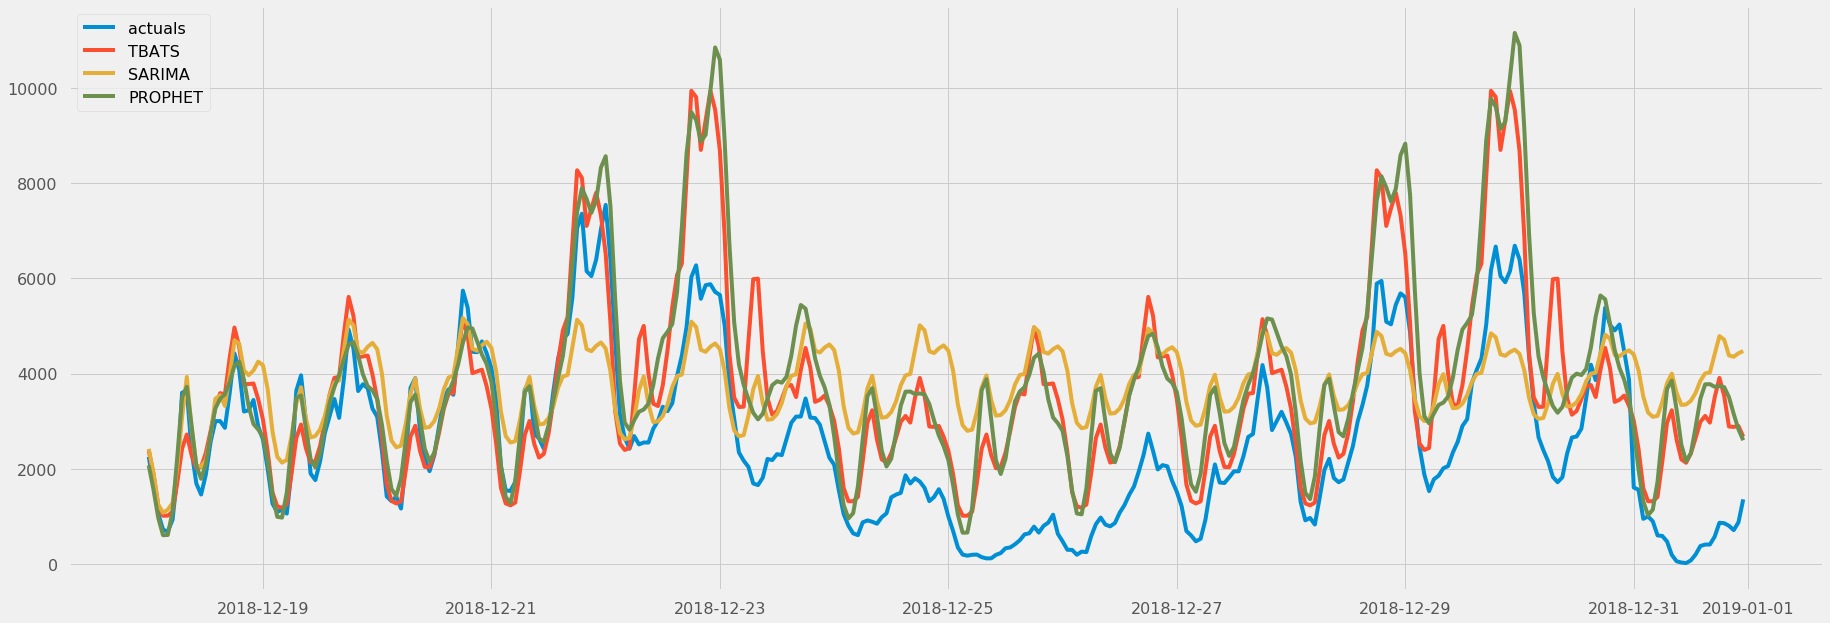

In [317]:
test_for_bryson=pd.DataFrame(data={'actual':com0_y_to_test,'tbats_forecast':com0_y_forecast,'sarima_forecast':com0_stepwise_arima_forecast,'PROPHET':df1.yhat})

fig=plt.subplots(figsize=(28,10))

plt.plot(test_for_bryson.actual,label='actuals')
    
plt.plot(test_for_bryson.tbats_forecast,label='TBATS')

plt.plot(test_for_bryson.sarima_forecast,label='SARIMA')

plt.plot(test_for_bryson.PROPHET,label='PROPHET')

plt.legend(loc='upper left')

In [192]:
pd.DataFrame(com0_y_forecast_full).to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\TBATS_community_0.csv')
pd.DataFrame(com1_y_forecast_full).to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\TBATS_community_1.csv')
pd.DataFrame(com2_y_forecast_full).to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\TBATS_community_2.csv')
pd.DataFrame(com3_y_forecast_full).to_csv(r'C:\Users\BRANDIN_HIRSCH\Desktop\TBATS_community_3.csv')

336